# Canadian housing prices under COVID-19 pandemic
Author: Ziheng Zhao

Date: December 2021

## Contents:
1. [Introduction](#1.-Introduction)
2. [Data Processing](#2.-Data-Processing)
3. [Data Exploration through Visualization and Mapping](#3.-Data-Exploration-through-Visualization-and-Mapping)
4. [Regression Analysis](#4.-Regression-Analysis)
5. [Regularization and Cross-Validation](#5.-Regularization-and-Cross-Validation)
6. [Random Forests and Neural Network](#6.-Random-Forests-and-Neural-Network)
7. [Summary and Further Studies](#7.-Summary-and-Further-Studies)
8. [Reference List](#8.-Reference-List)



## 1. Introduction
Since the beginning of 2020, COVID-19 pandemic has been fundamentally changing people's lives around the globe-- working, studying, shopping, entertainment, socializing... One of the most prominent impacts is the $\textbf{housing prices}$: in some places of the world, people have witnessed the sharpest rise in housing prices while there are also other areas where the real estate market tanked due to various reasons. 

The goal of this project is to investigate how COVID-19 pandemic had affected the housing prices in Canadian provinces. Particularly, this project studies whether total COVID-19 case number affects Canadian housing price and what prediction models work well! 

## 2. Data Processing

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection, preprocessing
)
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

# activate plot theme
#! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes
#import qeds
#qeds.themes.mpl_style();

### 2.1. COVID-19 data processing
- The data was provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) who shared their data on a public Github page. The JHU CSSE aggregates data from reliable sources, such as the World Health Organisation, national, and regional public health institutions. This data is publicly available, free of charge, and is updated every day.

- This COVID-19 data processing procedure is inspired by [Visualizing Corona Virus](https://github.com/ubcecon/ECON323_2021_Fall/blob/7d8d5654e435e09a90880529066df69aeccb5490/extra_notebooks/covid-trends.ipynb) and [COVID-19 data processing with Pandas DataFrame](https://towardsdatascience.com/covid-19-data-processing-58aaa3663f6).

In [10]:
# Cumulated confirmed cases
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
# Cumulated deaths due to COVID
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
# Cumulated recoveries from COVID
recoveries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed.tail()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/22/21,12/23/21,12/24/21,12/25/21,12/26/21,12/27/21,12/28/21,12/29/21,12/30/21,12/31/21
275,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,...,1588335,1604712,1620869,1636455,1651673,1666545,1680985,1694874,1714742,1731257
276,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,467391,467682,467682,467682,467682,468619,469452,469748,469748,469748
277,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,10103,10105,10109,10111,10115,10118,10123,10125,10126,10126
278,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,221880,225260,228932,231581,233120,234476,238383,243638,249193,254274
279,NaN,Zimbabwe,-19.015438,29.154857,0,0,0,0,0,0,...,199404,201344,202736,203746,204351,205449,207548,207548,211728,213258


- Melt dataframe into longer frame:

In [11]:
ids = ["Province/State","Country/Region", "Lat", "Long"]
confirmed = confirmed.melt(id_vars=ids, var_name="Date", value_name="total_cases")
deaths = deaths.melt(id_vars=ids,var_name="Date", value_name="deaths")
recoveries = recoveries.melt(id_vars=ids,var_name="Date", value_name="recoveries")
confirmed.tail()

,Province/State,Country/Region,Lat,Long,Date,total_cases
198795,NaN,Vietnam,14.058324,108.277199,12/31/21,1731257
198796,NaN,West Bank and Gaza,31.952200,35.233200,12/31/21,469748
198797,NaN,Yemen,15.552727,48.516388,12/31/21,10126
198798,NaN,Zambia,-13.133897,27.849332,12/31/21,254274
198799,NaN,Zimbabwe,-19.015438,29.154857,12/31/21,213258


- Merge three categories into one data frame called "covid":

In [12]:
covid = pd.merge(confirmed, deaths, on=ids.append("Date"), how='left')
covid = pd.merge(covid, recoveries, on=ids.append("Date"), how='left')

# convert Date values from string to datetime
covid["Date"] = pd.to_datetime(covid["Date"])
# fill N/A with 0
covid["recoveries"] = covid['recoveries'].fillna(0)
# fill missing province/states with ""
covid["Province/State"]=covid["Province/State"].fillna("")
# fixing datatypes for "recoveries"
covid["recoveries"] = covid["recoveries"].astype(int)

In [13]:
# Test with random rows:
covid.groupby("Country/Region").get_group("Canada").sample(5)

,Province/State,Country/Region,Lat,Long,Date,total_cases,deaths,recoveries
39525,Newfoundland and Labrador,Canada,53.1355,-57.6604,2020-06-11,261,3,0
151248,Nunavut,Canada,70.2998,-83.1076,2021-07-15,657,4,0
24126,Northwest Territories,Canada,64.8255,-124.8457,2020-04-17,5,0,0
113734,Yukon,Canada,64.2823,-135.0000,2021-03-03,72,1,0
176174,Yukon,Canada,64.2823,-135.0000,2021-10-12,824,10,0


- From data inspection, we can tell this data set does not contain daily recovery numbers in Canada, which is fine because what we primarily need is the overall confirmed number of cases. (Canada recovery data is counted by Country-wise rather than Province/State-wise)

In [14]:
# Drop recoveries and create Canada covid dataframe
cad_covid = covid.groupby("Country/Region").get_group("Canada")
cad_covid= cad_covid.drop("recoveries", axis = 1)
cad_covid.reset_index(drop=True, inplace=True)

# Rename "Province/State" as "Province"
cad_covid.rename(columns={"Province/State":"Province"}, inplace=True)
# Drop "Repatriated Travellers"
cad_covid.drop(cad_covid.loc[cad_covid["Province"] == "Repatriated Travellers"].index, inplace = True)

# Save a repicate dataframe for later visualization purpose
cad_covid_vis = cad_covid.copy()
cad_covid_vis.head()

,Province,Country/Region,Lat,Long,Date,total_cases,deaths
0,Alberta,Canada,53.9333,-116.5765,2020-01-22,0,0
1,British Columbia,Canada,53.7267,-127.6476,2020-01-22,0,0
2,Diamond Princess,Canada,0.0000,0.0000,2020-01-22,0,0
3,Grand Princess,Canada,0.0000,0.0000,2020-01-22,0,0
4,Manitoba,Canada,53.7609,-98.8139,2020-01-22,0,0


### 2.2 Multiple Listing Service® -- Housing Price Index data processing
- Load MLS® HPI data from [CREA (Canadian Real Estate Association)](https://www.crea.ca/housing-market-stats/mls-home-price-index/). "The MLS® HPI is based on the value home buyers assign to various housing attributes, which tend to evolve gradually over time. It therefore provides an 'apples to apples' comparison of home prices across the entire country." --[CREA](https://www.crea.ca/housing-market-stats/mls-home-price-index/)

In [15]:
# Read entire excel file as a dictionary
mls_dict = pd.read_excel(r'/Users/jauden/Desktop/ECON323_project/MLS®-HPI/Seasonally_adjusted.xlsx', sheet_name = None)

# Concatenate all all sheets in one single data frame
mls = pd.concat(mls_dict, axis = 0)

# Reset region index as column variable
mls.reset_index(level=0, inplace=True)
mls = mls.rename(columns={'level_0': 'Region'})

# Make sure to convert date values to datetime
mls["Date"] = pd.to_datetime(mls["Date"])

# Reset index numbers
mls.reset_index(drop=True, inplace=True)
mls.head()

,Region,Date,Composite_HPI_SA,Single_Family_HPI_SA,One_Storey_HPI_SA,Two_Storey_HPI_SA,Townhouse_HPI_SA,Apartment_HPI_SA,Composite_Benchmark_SA,Single_Family_Benchmark_SA,One_Storey_Benchmark_SA,Two_Storey_Benchmark_SA,Townhouse_Benchmark_SA,Apartment_Benchmark_SA
0,AGGREGATE,2005-01-01,100.0,100.0,100.0,100.0,100.0,100.0,245200,262600,215400,301600,207200.0,188800.0
1,AGGREGATE,2005-02-01,100.4,100.3,100.3,100.3,100.4,100.5,246200,263500,216000,302500,208100.0,189800.0
2,AGGREGATE,2005-03-01,100.7,100.7,100.7,100.8,100.7,100.6,246900,264400,216900,303900,208600.0,189900.0
3,AGGREGATE,2005-04-01,101.0,101.0,101.1,101.0,101.0,100.8,247700,265200,217700,304600,209200.0,190400.0
4,AGGREGATE,2005-05-01,101.2,101.1,101.4,101.2,101.2,101.0,248200,265600,218400,305100,209700.0,190700.0


- Add "Province" to each row, based on geographical locations

In [16]:
# British Columbia
bc_regions = ["VANCOUVER_ISLAND", "VICTORIA", "LOWER_MAINLAND", "GREATER_VANCOUVER", "FRASER_VALLEY", 
              "CHILLIWACK_AND_DISTRICT", "KAMLOOPS_AND_DISTRICT", "INTERIOR_BC"]
# Alberta
ab_regions = ["CALGARY", "EDMONTON"]
# Saskatchewan
sa_regions = ["SASKATCHEWAN", "REGINA", "SASKATOON"]
# Manitoba
ma_regions = ["WINNIPEG"]
# Ontario
on_regions = ["BANCROFT_AND_AREA", "BARRIE_AND_DISTRICT", "BRANTFORD_REGION", "CAMBRIDGE", "GREY_BRUCE_OWEN_SOUND",
              "GUELPH_AND_DISTRICT", "HAMILTON_BURLINGTON", "HURON_PERTH", "KAWARTHA_LAKES", "KINGSTON_AND_AREA", 
             "KITCHENER_WATERLOO", "LAKELANDS", "LONDON_ST_THOMAS", "MISSISSAUGA", "NIAGARA_REGION", "NORTH_BAY",
             "NORTHUMBERLAND_HILLS", "OAKVILLE_MILTON", "OTTAWA", "PETERBOROUGH_AND_KAWARTHAS", "QUINTE_AND_DISTRICT",
             "SIMCOE_AND_DISTRICT", "TILLSONBURG_DISTRICT", "GREATER_TORONTO", "WOODSTOCK_INGERSOLL"]
# Quebec
qu_regions = ["MONTREAL_CMA", "QUEBEC_CMA"]
# New Brunswick
nb_regions = ["FREDERICTON", "GREATER_MONCTON", "SAINT_JOHN_NB", "NEW_BRUNSWICK"]
# Newfoundland and Labrador
nl_regions = ["ST_JOHNS_NL", "NEWFOUNDLAND_AND_LABRADOR"]

# Add "Province" column according to geographical locations
mls["Province"] = ["British Columbia" if x in (bc_regions) 
                   else "Alberta" if x in (ab_regions) 
                   else "Saskatchewan" if x in (sa_regions)
                   else "Manitoba" if x in (ma_regions)
                   else "Ontario" if x in (on_regions)
                   else "Quebec" if x in (qu_regions)
                   else "New Brunswick" if x in (nb_regions)
                   else "Newfoundland and Labrador" if x in (nl_regions)
                   else None for x in mls["Region"]]

- Calculate provincial average housing data in each month

In [17]:
# Calculate provincial average housing data in each month by grouping both date and province
cad_mls = mls.groupby(["Date", "Province"]).agg(np.mean)
cad_mls.reset_index(level=0, inplace=True)
cad_mls.reset_index(level=0, inplace=True)
cad_mls.tail()

,Province,Date,Composite_HPI_SA,Single_Family_HPI_SA,One_Storey_HPI_SA,Two_Storey_HPI_SA,Townhouse_HPI_SA,Apartment_HPI_SA,Composite_Benchmark_SA,Single_Family_Benchmark_SA,One_Storey_Benchmark_SA,Two_Storey_Benchmark_SA,Townhouse_Benchmark_SA,Apartment_Benchmark_SA
1611,New Brunswick,2021-10-01,209.625,210.500000,213.075000,205.975000,179.250000,199.350000,260150.000000,262075.000000,258775.000000,263750.000000,174750.000000,209050.000000
1612,Newfoundland and Labrador,2021-10-01,225.200,228.100000,245.300000,201.650000,205.400000,172.500000,301600.000000,305650.000000,304000.000000,294500.000000,274400.000000,232950.000000
1613,Ontario,2021-10-01,357.760,361.808000,358.956000,362.564000,359.766667,307.593750,716008.000000,759388.000000,735912.000000,765436.000000,578105.555556,495243.750000
1614,Quebec,2021-10-01,244.400,263.800000,263.900000,264.550000,240.450000,208.400000,404200.000000,455100.000000,385800.000000,544300.000000,395350.000000,298400.000000
1615,Saskatchewan,2021-10-01,239.300,247.533333,249.866667,245.766667,206.433333,205.766667,290466.666667,307933.333333,283366.666667,374033.333333,244300.000000,186666.666667


### 2.3 Merge two data sets
- Merge COVID-19 case data and CREA MLS Housing Price Index data:

In [18]:
# In order to merge with monthly MLS HPI, we only keep COVID data at the first day of each month:
cad_covid['year'] = cad_covid["Date"].map(lambda x: x.year)
cad_covid['month'] = cad_covid["Date"].map(lambda x: x.month)
cad_covid['day'] = cad_covid["Date"].map(lambda x: x.day)
cad_covid = cad_covid[(cad_covid['day']==1)]
cad_covid= cad_covid.drop(["year", "month", "day"], axis = 1)
cad_covid.reset_index(drop=True, inplace=True)
cad_covid.tail()

,Province,Country/Region,Lat,Long,Date,total_cases,deaths
340,Ontario,Canada,51.2538,-85.3232,2021-12-01,627723,10057
341,Prince Edward Island,Canada,46.5107,-63.4168,2021-12-01,372,0
342,Quebec,Canada,52.9399,-73.5491,2021-12-01,449366,11581
343,Saskatchewan,Canada,52.9399,-106.4509,2021-12-01,81074,927
344,Yukon,Canada,64.2823,-135.0000,2021-12-01,1519,13


In [19]:
# Merge cad_covid and cad_mls
mls_covid = pd.merge(cad_covid, cad_mls, on=ids.append("Date"), how='inner')
mls_covid["total_cases"] = mls_covid["total_cases"].astype("float")
mls_covid["deaths"] = mls_covid["deaths"].astype("float")
mls_covid.head()

,Province,Country/Region,Lat,Long,Date,total_cases,deaths,Composite_HPI_SA,Single_Family_HPI_SA,One_Storey_HPI_SA,Two_Storey_HPI_SA,Townhouse_HPI_SA,Apartment_HPI_SA,Composite_Benchmark_SA,Single_Family_Benchmark_SA,One_Storey_Benchmark_SA,Two_Storey_Benchmark_SA,Townhouse_Benchmark_SA,Apartment_Benchmark_SA
0,Alberta,Canada,53.9333,-116.5765,2020-02-01,0.0,0.0,178.100,182.30,185.1000,180.4000,166.05,163.050,359450.0,406900.0,375250.0,456350.0,248900.0,217850.0
1,British Columbia,Canada,53.7267,-127.6476,2020-02-01,1.0,0.0,250.225,244.40,246.2625,243.0375,238.40,272.550,687687.5,830575.0,725875.0,937450.0,533700.0,434575.0
2,Manitoba,Canada,53.7609,-98.8139,2020-02-01,0.0,0.0,220.900,226.50,228.1000,226.1000,192.90,179.800,271100.0,281300.0,269800.0,299400.0,225100.0,194200.0
3,New Brunswick,Canada,46.5653,-66.4619,2020-02-01,0.0,0.0,146.800,147.15,147.6750,145.4250,122.20,148.475,181850.0,182825.0,179125.0,185700.0,119100.0,156750.0
4,Newfoundland and Labrador,Canada,53.1355,-57.6604,2020-02-01,0.0,0.0,200.150,201.20,215.7500,179.3500,190.95,175.450,268250.0,269750.0,267700.0,261950.0,255100.0,236950.0


## 3. Data Exploration through Visualization and Mapping

### 3.1 COVID-19 case data visualization:

Plot total COVID case number/death number trends for British Columbia

<AxesSubplot:title={'center':'COVID-19 total case & death number in Ontario'}, xlabel='Date'>

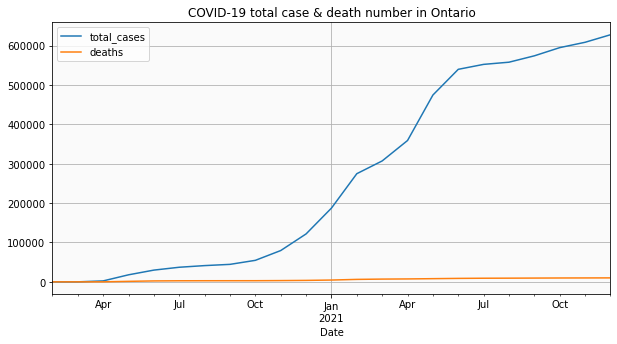

In [20]:
# Set background color
bgcolor = (250/255, 250/255, 250/255)

def covidplot(province):
    df = cad_covid.groupby("Province").get_group(province)
    ax = df.groupby("Date").sum().reset_index().plot(x='Date', y=["total_cases", "deaths"], 
                                                     title=f"COVID-19 total case & death number in {province}",
                                                     figsize = (10, 5), grid=True)
    ax.set_facecolor(bgcolor)
    return(ax)

# covidplot("British Columbia")
covidplot("Ontario")

Plot total COVID case number for each province in Canada

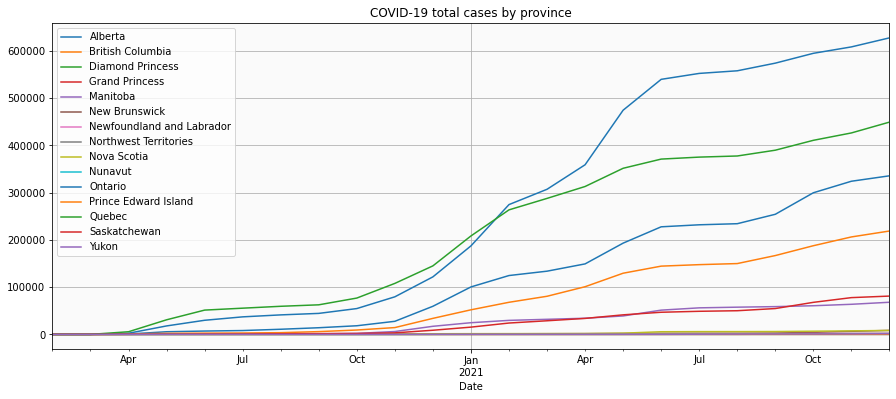

In [21]:
# Alterative to applying the previous function 15 times
fig, ax = plt.subplots(figsize=(15,6))
for province, df in cad_covid.reset_index().groupby("Province"):
    df.plot(x="Date",y="total_cases", ax=ax,label=province, grid=True)
ax.set_title("COVID-19 total cases by province")
ax.set_facecolor(bgcolor)
ax.legend(loc="upper left")

Ploy canadian provincial total confirmed cases evolutions: (Further exercises from [Visualizing Corona Virus](https://github.com/ubcecon/ECON323_2021_Fall/blob/7d8d5654e435e09a90880529066df69aeccb5490/extra_notebooks/covid-trends.ipynb))

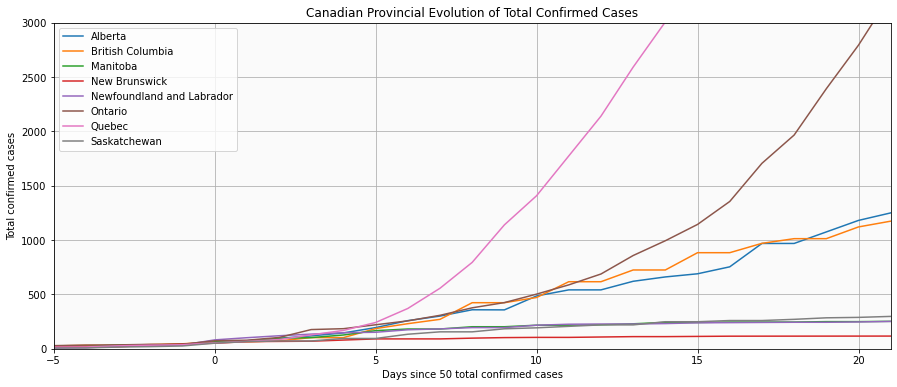

In [22]:
# Create column with days since cases reached basecount
basecount=50
basedate = cad_covid_vis.query(f"total_cases>={basecount}").groupby(["Province"])["Date"].min().reset_index().rename(columns={"Date":"basedate"})
basedate_df = pd.merge(cad_covid_vis, basedate.reset_index(), on=["Province"])
basedate_df["dayssince"] = (basedate_df["Date"]-basedate_df["basedate"]).dt.days; # Negative meaning it is before teh base date

# Only look at provinces that are in the merged "mls_covid" data set
filtered_df = basedate_df[basedate_df["Province"].isin(["British Columbia", "Ontario", "Alberta",
                                              "New Brunswick", "Newfoundland and Labrador",
                                              "Quebec", "Manitoba", "Saskatchewan"])];

fig, ax = plt.subplots(figsize=(15,6))
for province, df in filtered_df.groupby("Province"):
    df.plot(x="dayssince",y="total_cases", ax=ax,label=province, grid=True, xlim=[-5, 21], ylim=[0,3000])
ax.set_xlabel(f"Days since {basecount} total confirmed cases")
ax.set_ylabel("Total confirmed cases")
ax.set_title("Canadian Provincial Evolution of Total Confirmed Cases")
ax.set_facecolor(bgcolor)

From COVID data exploration, we can see that among the 8 target provinces:
- Ontairo had the most severe level of pandemic, in terms of the confirmed cases/deaths. 
- Quebec had witnessed a significantly rapid evolution in the number of confirmed cases right after hitting 50 total confirmed cases. 
- Saskatchewan, New Brunswick, Manitoba, Newfoundland and Labrador are provinces that are much less suffered from COVID (total case number/speed of evolution), potentially due to its remote geographical locations and sparse population. 

### 3.2 CREA MLS® HPI data visualization

Plot any single province HPI data:

<AxesSubplot:title={'center':'MLS Housing Price Index in British Columbia'}, xlabel='Date'>

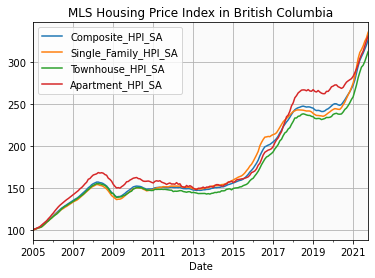

In [23]:
def hpi_plot(province):
    df=cad_mls.groupby("Province").get_group(province)
    ax = df.groupby("Date").sum().reset_index().plot(x='Date', y=["Composite_HPI_SA", "Single_Family_HPI_SA", 
                                                                  "Townhouse_HPI_SA", "Apartment_HPI_SA"], 
                                                     title=f"MLS Housing Price Index in {province}", grid=True)
    ax.set_facecolor(bgcolor)
    return(ax)

hpi_plot("British Columbia")

Plot all six types of HPI data for any single province:

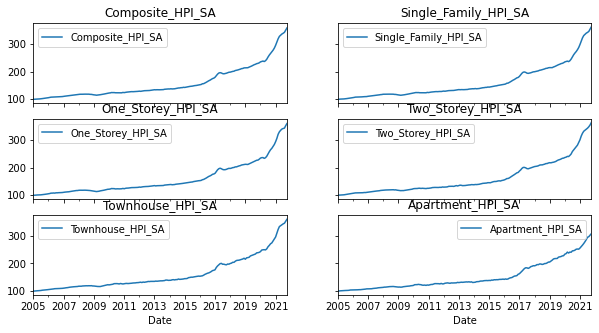

In [24]:
def hpi_panel_plot(province):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (10, 5), sharey=True,sharex=True)
    df = cad_mls.groupby("Province").get_group(province)
    df.plot(x="Date", y="Composite_HPI_SA", ax=axes[0,0]); axes[0,0].set_title('Composite_HPI_SA')
    df.plot(x="Date", y="Single_Family_HPI_SA", ax=axes[0,1]); axes[0,1].set_title('Single_Family_HPI_SA')
    df.plot(x="Date", y="One_Storey_HPI_SA", ax=axes[1,0]); axes[1,0].set_title('One_Storey_HPI_SA')
    df.plot(x="Date", y="Two_Storey_HPI_SA", ax=axes[1,1]); axes[1,1].set_title('Two_Storey_HPI_SA')
    df.plot(x="Date", y="Townhouse_HPI_SA", ax=axes[2,0]); axes[2,0].set_title('Townhouse_HPI_SA')
    df.plot(x="Date", y="Apartment_HPI_SA", ax=axes[2,1]); axes[2,1].set_title('Apartment_HPI_SA')

hpi_panel_plot("Ontario")

Plot HPI data for all 8 target provinces:

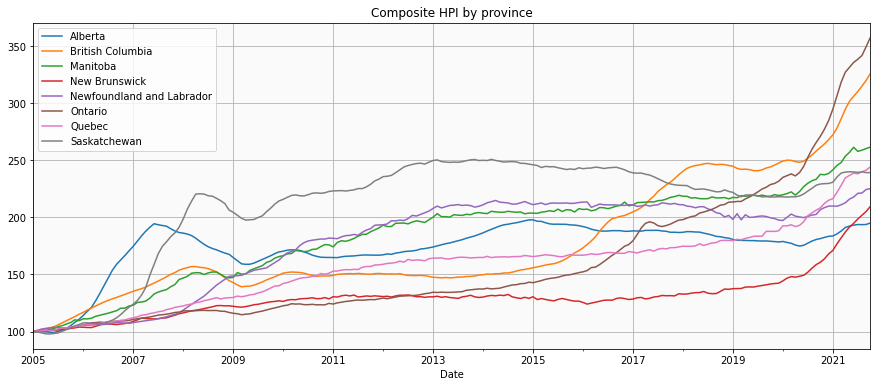

In [25]:
fig, ax = plt.subplots(figsize=(15,6))
for province, df in cad_mls.reset_index().groupby("Province"):
    df.plot(x="Date",y="Composite_HPI_SA", ax=ax,label=province, grid=True)
ax.set_title("Composite HPI by province")
ax.set_facecolor(bgcolor)

From housing price data exploration, we can see that:  
- Housing price indexes exhibit an overall increasing trends, dispite fluctuations during 2008/09 financial crisis. 
- Interesting point here is that from previous graph, we can clearly see: $\textbf{"an abnormal" spike in Canadian housing prices approximately right at the beginning 2020, which is the time when COVID-19 pandemic started."}$

### 3.3 Merged data set visualization

Interactively graph Canada and oour target provinces with COVID and MLS HPI information. Adapted from textbook [Mapping in Python](https://datascience.quantecon.org/applications/maps.html)

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point

In [27]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.palettes import brewer
output_notebook()
import json

Loading BokehJS ...

In [28]:
# Narrow down our scope to the 2021-10-01 data (shrink time-series data to cross-sectional data)
map_df = mls_covid.copy()
map_df["Coordinates"] = list(zip(map_df.Long, map_df.Lat))
map_df = map_df[map_df["Date"]=="2021-10-01"]
map_df = map_df.reset_index()
map_df["Coordinates"] = map_df["Coordinates"].apply(Point)
map_df = gpd.GeoDataFrame(map_df, geometry="Coordinates")

In [29]:
# Import Canadian province shapefile
province = gpd.read_file('/Users/jauden/Desktop/ECON323_project/lpr_000b16a_e/lpr_000b16a_e.shp')
province = province.rename(columns={'PRENAME': 'Province'})
# Merge with original map_df
map_df2 = pd.merge(map_df, province, on=ids.append("Province"), how='left')
map_df2 = map_df2.drop('Coordinates', axis = 1)
#map_df2.head()

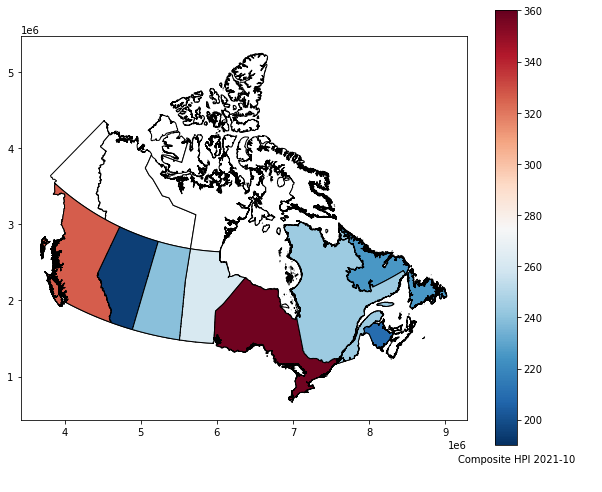

In [30]:
# Plot static graph to visualize the composite housing price index in eight target provinces
fig, gax = plt.subplots(figsize = (10,8))

# Plot the provinces
province.plot(ax = gax, edgecolor='black', color='white')

# Plot the counties and pass 'Composite_HPI_SA' as the data to color
map_df2.plot(
    ax=gax, edgecolor='black', column='Composite_HPI_SA', legend=True, cmap='RdBu_r',
    vmin=190, vmax=360
)

gax.annotate('Composite HPI 2021-10',xy=(0.76, 0.06),  xycoords='figure fraction')

# plt.axis('off')

plt.show()

In [31]:
# Additional data processing in preparation for interactive map visualization
map_df3 = pd.merge(map_df, province, on=ids.append("Province"), how="outer")
map_df3 = map_df3.drop(["Country/Region", "Lat", "Long", "Date", "index", "Coordinates","PRUID", "PRNAME", "PRFNAME", "PREABBR", "PRFABBR", 
                        "Single_Family_HPI_SA", "One_Storey_HPI_SA", "Two_Storey_HPI_SA", "Townhouse_HPI_SA",
                        "Composite_Benchmark_SA", "Single_Family_Benchmark_SA", "One_Storey_Benchmark_SA", "Two_Storey_Benchmark_SA",
                        "Townhouse_Benchmark_SA", "Apartment_Benchmark_SA"], axis = 1)
map_df3 = map_df3.rename(columns={'geometry': 'Coordinates'})
map_df3["total_cases"]=map_df3["total_cases"].fillna(0)
map_df3["deaths"]=map_df3["deaths"].fillna(0)
map_df3["Composite_HPI_SA"]=map_df3["Composite_HPI_SA"].fillna(0)
#map_df3.head()

In [32]:
#Convert data to geojson for bokeh
cad_geojson=GeoJSONDataSource(geojson=map_df3.to_json())

color_mapper = LinearColorMapper(palette = brewer['RdBu'][10], low = 190, high = 360)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
# We can adjust the graph as we want to show what elements are included in the tooptips
hover = HoverTool(tooltips = [ ('Province','@Province'),('Total cases', '@total_cases'),
                               ('Total deaths','@deaths'),
                               ('Composite HPI','@Composite_HPI_SA'),
                               ('Apartment HPI','@Apartment_HPI_SA')])
p = figure(title="Housing Price Index(HPI) for 8 targeted Canadian Provinces with COVID info(2021-10-01)", tools=[hover])
p.patches("xs","ys",source=cad_geojson,
          fill_color = {'field' :'Composite_HPI_SA', 'transform' : color_mapper})
p.add_layout(color_bar, 'below')
# show(p)

## 4. Regression Analysis

Key question of interest: $\textbf{Does COVID-19 significantly elevate the housing price across Canada?}$

The intuition based on basic economic logics can be unclear: when COVID hit and many industry shut down, people's income revenue tend to be negatively impacted, which puts downward pressure on market housing index if housing is a normal good. However, on the other hand, it can also be the case where people were having extra abundance on savings that can be used to purchase a home, because during lockdowns they were having much less transportation/entermainment/socialization... This will instead put a upward pressure on market housing index. 

So the overall effects of COVID on housing price index can be ambiguous simply from theoretical reasoning. We will be using regression to analyze the statistical relationship between COVID and HPI across provinces in Canada, and identity provincial idiosycrasy. 

### 4.1 Base case: Linear regression with one regressor

First, use a scatter plot and the most simple linear regression to get a sense of the relationship between Composite HPI and total number of COVID cases:

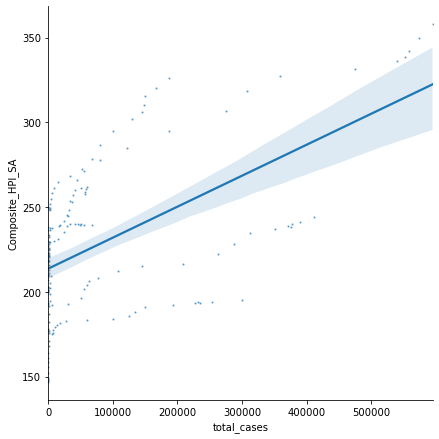

In [33]:
def var_scatter(df, ax=None, var="total_cases"):
    if ax is None:
        _, ax = plt.subplots()
    df.plot.scatter(x=var , y="Composite_HPI_SA", s=1.5, ax=ax)
    ax.set_facecolor(bgcolor)

    return ax

# var_scatter(mls_covid);

sns.lmplot(
    data=mls_covid, x="total_cases", y="Composite_HPI_SA", height=6,
    scatter_kws=dict(s=1.5, alpha=0.5)
);

Then create fit model (which will produce the same results as statsmodel OLS):

In [34]:
# construct the model instance
total_cases_model = linear_model.LinearRegression()

# fit the model
X = mls_covid.drop(["Province", "Country/Region", "Date"], axis=1).copy()
y = mls_covid["Composite_HPI_SA"]
total_cases_model.fit(X[["total_cases"]], y)

# print the coefficients
beta_0 = total_cases_model.intercept_
beta_1 = total_cases_model.coef_[0]

print(f"Fit model: Composite_HPI = {beta_0: f} + {beta_1: f} total_cases")

Fit model: Composite_HPI =  213.679875 +  0.000183 total_cases


Double check the coefficients are correct by substituting data points in the regression expression to reconstruct the plot:

Text(0.5, 1.0, 'Simple linear regression')

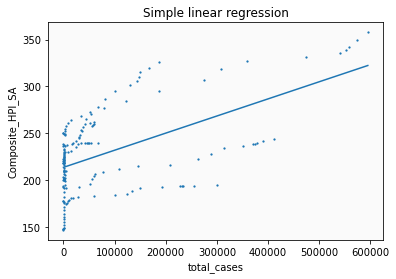

In [35]:
ax = var_scatter(mls_covid)
# points for the line
x = np.array([0, mls_covid["total_cases"].max()])
ax.plot(x, beta_0 + beta_1*x)
ax.set_title("Simple linear regression")

Run simple predictions:

In [36]:
predicted_case = 800000
comp_hpi = total_cases_model.predict([[predicted_case]])[0]
print(f"The model predicts when total COVID case number is {predicted_case}, composite housing price index would be {comp_hpi: f}")

The model predicts when total COVID case number is 800000, composite housing price index would be  359.809206


In [37]:
# Quick implementation for simple OLS regression to get regression table:
import statsmodels.api as sm
import statsmodels.formula.api as smf
lm = sm.OLS(mls_covid["Composite_HPI_SA"], sm.add_constant(mls_covid["total_cases"]))   # Manually add constant here for statsmodels OLS. 
lm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Composite_HPI_SA   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     73.25
Date:                Fri, 31 Dec 2021   Prob (F-statistic):           7.35e-15
Time:                        22:12:58   Log-Likelihood:                -843.88
No. Observations:                 168   AIC:                             1692.
Df Residuals:                     166   BIC:                             1698.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         213.6799      3.305     64.658      0.000     207.155     220.205
total_cases     0.0002   2.13e-05      8.559      0.000       0.000       0.000
==============================================================================
Omnibus:                       20.628   Durbin-Watson:                   2.731
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.333
Skew:                          -0.090   Prob(JB):                       0.0421
Kurtosis:                       2.066   Cond. No.                     1.79e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$\textbf{Temporary conclusion}$ from simple linear regressions above: without any control, the coefficient on "total_cases" is positive (0.0002). And the effect of total COVID confirmed cases on composite housing price index is $\textbf{ statistically significant}$ at 5% significance level. 

$\textbf{Observations and Problems:}$ From the fitted linear regression line in the scatter plot above, the correlation between total case number and HPI is positive. 

But it needs further analysis in that 1) Omitted Variable Bias: we only include one regressor without any controls. 2) We are dealing with time-series data, where we have many months since Feburary 2020 and also have housing price indexes across eight provinces. So, we need to :
- add more control variables to reduce as much omitted variable bias (OVB) as possible;
- incorporate the time fixed effects on HPI;
- incorporate the province fixed effects on HPI to reveal a "closer-to-causal" relationship

(These issues will be solved one by one below)

PS: the data points clustered at "total_cases" = 0 are primarily because more oftenly, provinces were having a lower number of cases. (i.e., Saskatchewan, New Brunswick, Manitoba, Newfoundland and Labrador)

### 4.2 Linear regression with non-linear rellationship

Earlier we primarily used "total_cases" as the sole regressor. We recognize "total_cases" and "deaths" may be highly correlated. So, to testify whether sole regressor of "total_cases" is good enough or not, we now create "mortality" = "deaths" / "total_cases" and compare minimum squared errors (MSE) as we use different regressors.

In [38]:
X2 = X[["total_cases"]].copy()
X2["mortality"] = X["deaths"] / X["total_cases"]
# Fill NA for mortality
X2["mortality"] = X2['mortality'].fillna(0)

mortalilty_lr_model = linear_model.LinearRegression()
mortalilty_lr_model.fit(X2, y)

old_mse = metrics.mean_squared_error(y, total_cases_model.predict(X2[["total_cases"]]))
new_mse = metrics.mean_squared_error(y, mortalilty_lr_model.predict(X2))
print(f"The mse changed from {old_mse: f} to {new_mse: f} by including new feature--COVID mortality rate")

The mse changed from  1350.538800 to  1339.608649 by including new feature--COVID mortality rate


From the exercise above, we can see MSE is reduced by a bit but overall performance should be very similar. MSEs are still very large because we still haven't consider any other control variables or time/province fixed effects.

### 4.3 Multi-variate Linear regression

Goal: add more controls to reduce as much omitted variable bias as possible. 
- Question: Is "deaths" (number of deaths due to COVID) a good control variable to be added here?
- Answer: Mostly not! This is becasue "deaths" is very likely to be a "outcome" of the regressor of interest--"total_cases". Adding it will change the composition of the comparision groups. Thus, including bad controls like "deaths" will be a bad idea.

Therefore, in addition to the "total_cases" regressor, I primarily added geographical location controls: longitude, latitude

Text(0.5, 1.0, 'Comparison between single/multi-variate regression model')

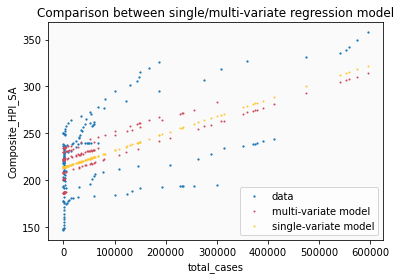

In [39]:
# multi-variate regression
colors = ['#165aa7', '#cb495c', '#fec630', '#bb60d5', '#f47915', '#06ab54', '#002070', '#b27d12', '#007030']
X_multi = X.drop(["Composite_HPI_SA", "Single_Family_HPI_SA", "One_Storey_HPI_SA", "Two_Storey_HPI_SA", "Townhouse_HPI_SA", "Apartment_HPI_SA",
           "Composite_Benchmark_SA", "Single_Family_Benchmark_SA", "One_Storey_Benchmark_SA", "Two_Storey_Benchmark_SA", "Townhouse_Benchmark_SA",
           "Apartment_Benchmark_SA", "deaths"], axis = 1)
multi_lr_model = linear_model.LinearRegression()
multi_lr_model.fit(X_multi, y)

# Original data plots
ax = var_scatter(mls_covid)

def scatter_model(model, X, ax=None, color=colors[1], x="total_cases"):
    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(X[x], model.predict(X), c=color, alpha=1, s=1)
    return ax

# Multi-variate regression model plots
scatter_model(multi_lr_model, X_multi, ax, color=colors[1])
# Base case (single-variate) regression model plots
scatter_model(total_cases_model, X[["total_cases"]], ax, color=colors[2])
ax.legend(["data", "multi-variate model", "single-variate model"]);
ax.set_facecolor(bgcolor)
ax.set_title("Comparison between single/multi-variate regression model")

Great! We have moved one step further by including more good control variables. The next thing to do is to add fixed effects in the regression.  

### 4.4 Linear regression with time and province fixed effects

Goal: add time and province fixed effects by creating series of time dummies and province dummies.

Implementation: I created ultimate linear regression model--"all_lr_model" which incorporates both latitude/longitude controls and time/province fixed effects.

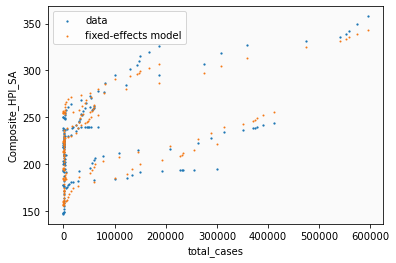

In [40]:
# Create time dummies for each month
time_dummies = pd.get_dummies(mls_covid["Date"], drop_first=True)
X_all = X_multi.join(time_dummies)

# Create province dummies for each of the eight target provinces
province_dummies = pd.get_dummies(mls_covid["Province"], drop_first=True)
X_all = X_all.join(province_dummies)

all_lr_model = linear_model.LinearRegression()
all_lr_model.fit(X_all, y)

ax = var_scatter(mls_covid)
scatter_model(all_lr_model, X_all, ax, color=colors[4])
ax.set_facecolor(bgcolor)
ax.legend(["data", "fixed-effects model"]);

PS: In the codes below, I ignored one warning which is about "covariance of constraints does not have full rank". I think the reason it comes up is that I used clustered standard errors here to control for idiosyncrasy from province to province. There are eight clusters (provinces) but 30 controls (including all the fixed effects dummies).

In [41]:
import warnings
warnings.filterwarnings("ignore") # Here is a warning about covariance of constraints does not have full rank, explained down below
all_ols = sm.OLS(mls_covid["Composite_HPI_SA"], sm.add_constant(X_all))   # Manually add constant here for statsmodels OLS. 
# Use clustered standard error here because we are adding province fixed effects that are categorical controls.
all_ols.fit().get_robustcov_results(cov_type='cluster', groups=mls_covid["Province"]).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Composite_HPI_SA   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     4.721
Date:                Fri, 31 Dec 2021   Prob (F-statistic):             0.0289
Time:                        22:12:58   Log-Likelihood:                -600.26
No. Observations:                 168   AIC:                             1259.
Df Residuals:                     139   BIC:                             1349.
Df Model:                          28                                         
Covariance Type:              cluster                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         3.0282      0.166     18.289      0.000       2.637       3.420
Lat                           4.9590      0.083     60.013      0.000       4.764       5.154
Long                          0.9473      0.018     51.797      0.000       0.904       0.991
total_cases                9.327e-05   4.17e-05      2.239      0.060   -5.24e-06       0.000
2020-03-01 00:00:00           0.9375      0.440      2.129      0.071      -0.104       1.979
2020-04-01 00:00:00          -0.5759      0.459     -1.255      0.250      -1.661       0.509
2020-05-01 00:00:00          -0.3028      0.761     -0.398      0.703      -2.102       1.496
2020-06-01 00:00:00           1.3456      1.134      1.187      0.274      -1.335       4.027
2020-07-01 00:00:00           4.6015      1.536      2.996      0.020       0.970       8.233
2020-08-01 00:00:00           7.3993      2.019      3.665      0.008       2.625      12.174
2020-09-01 00:00:00           9.8395      2.481      3.966      0.005       3.973      15.706
2020-10-01 00:00:00          12.3075      2.707      4.546      0.003       5.906      18.709
2020-11-01 00:00:00          13.8535      2.884      4.803      0.002       7.033      20.674
2020-12-01 00:00:00          14.8480      3.360      4.419      0.003       6.902      22.794
2021-01-01 00:00:00          15.3785      4.113      3.739      0.007       5.654      25.103
2021-02-01 00:00:00          17.9918      4.936      3.645      0.008       6.319      29.664
2021-03-01 00:00:00          22.1181      5.646      3.917      0.006       8.767      35.469
2021-04-01 00:00:00          25.7362      6.398      4.022      0.005      10.606      40.866
2021-05-01 00:00:00          26.1690      7.611      3.438      0.011       8.171      44.167
2021-06-01 00:00:00          27.0020      8.711      3.100      0.017       6.405      47.599
2021-07-01 00:00:00          27.8744      9.143      3.049      0.019       6.256      49.493
2021-08-01 00:00:00          29.5938      9.684      3.056      0.018       6.694      52.494
2021-09-01 00:00:00          31.3937     10.253      3.062      0.018       7.150      55.637
2021-10-01 00:00:00          33.0338     11.285      2.927      0.022       6.348      59.719
British Columbia            107.4655      1.777     60.479      0.000     103.264     111.667
Manitoba                     47.9906      2.912     16.479      0.000      41.104      54.877
New Brunswick               -14.0376      3.105     -4.521      0.003     -21.379      -6.696
Newfoundland and Labrador   -17.4320      3.079     -5.662      0.001     -24.712     -10.152
Ontario                      77.7999      6.068     12.822      0.000      63.452      92.148
Quebec                      -11.6824      4.445     -2.628      0.034     -

$\textbf{Conclusion}$ from various linear regressions above: with controls in latitude/longitude and time/province fixed effects, the coefficient on "total_cases" is positive but very small (9.327e-05). The effect of total COVID confirmed cases on composite housing price index is $\textbf{NOT statistically significant}$ at 5% significance level. 

By adding more controls and fixed effects, we obtained a different conclusion to our hypothesis than the previous temporary conclusion. But we are not satisfied with it yet because we are very worried about the $\textbf{overfitting issue}$. So next, we will run Lasso regression and do cross-validation for proper regularization parameter.

## 5. Regularization and Cross-Validation

### 5.1 Lasso Regression

In [42]:
lasso_model = linear_model.Lasso()  # alpha = 1 by default
lasso_model.fit(X_all, y)

lasso_coefs = pd.Series(dict(zip(list(X_all), lasso_model.coef_)))
all_lr_model_coefs = pd.Series(dict(zip(list(X_all), all_lr_model.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=all_lr_model_coefs))
coefs

,lasso,linreg
Lat,4.056036,0.560903
Long,0.294190,0.724713
total_cases,0.000153,0.000093
2020-03-01 00:00:00,-0.000000,0.937535
2020-04-01 00:00:00,-0.000000,-0.575934
2020-05-01 00:00:00,-0.000000,-0.302786
2020-06-01 00:00:00,-0.000000,1.345603
2020-07-01 00:00:00,-0.000000,4.601452
2020-08-01 00:00:00,-0.000000,7.399292
2020-09-01 00:00:00,-0.000000,9.839532


Compute and compare Lasso coefficients for many alphas (the lasso path):

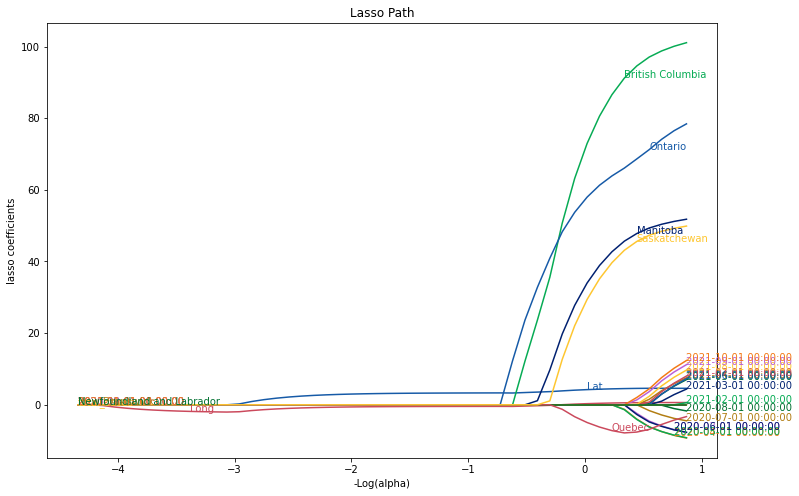

In [43]:
from itertools import cycle
alphas = np.exp(np.linspace(10, -2, 50))
alphas, coefs_lasso, _ = linear_model.lasso_path(X_all, y, alphas=alphas, fit_intercept=True, max_iter=10000)

# plotting
fig, ax = plt.subplots(figsize=(12, 8))
color_cycle = cycle(colors)
log_alphas = -np.log10(alphas)
for coef_l, c, name in zip(coefs_lasso, color_cycle, list(X_all)):
   ax.plot(log_alphas, coef_l, c=c)
   ax.set_xlabel('-Log(alpha)')
   ax.set_ylabel('lasso coefficients')
   ax.set_title('Lasso Path')
   ax.axis('tight')
   maxabs = np.max(np.abs(coef_l))
   i = [idx for idx in range(len(coef_l)) if abs(coef_l[idx]) >= (0.9*maxabs)][0]
   xnote = log_alphas[i]
   ynote = coef_l[i]
   ax.annotate(name, (xnote, ynote), color=c)

Here, we first used default regularization parameter $\alpha = 1$ in lasso regression. And we "filtered" out many controls that are unable to provide sufficient predictive power to be worth considering alongside the other controls. 

$\textbf{Some take-aways:}$
- Provinces (especially British Columbia and Ontario) are having tremendous effect on the overall average composite HPI level. This is understandable and reasonable because these two are the most populous/prosperous regions where the average HPIs are much higher than national average. 
- Time fixed effects are limited here because they are all filtered out and exhibit zeros. This may be surprising at first when we think about the inflation effects. But it also makes sense that inflation is limited considering the time span is relatively short from January 2020 to October 2021. 

### 5.2 Train-Test Split Evaluation


In [44]:
def fit_and_report_mses(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, model.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, model.predict(X_test))
    )
# Method 1: Use the first 50 observations for training and the rest for testing
# n_test = 50
# X_train = X_all.iloc[:n_test, :]
# X_test = X_all.iloc[n_test:, :]
# y_train = y.iloc[:n_test]
# y_test = y.iloc[n_test:]

# Method 2: Holdout useing 75% of the data for training and the rest for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_all, y, test_size=0.25)

# Fit the linear regression model
fit_and_report_mses(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)

{'mse_train': 69.59676574546604, 'mse_test': 119.00926331674277}

In [45]:
# Fit the lasso regression model (alpha = 1 by default for Lasso)
fit_and_report_mses(linear_model.Lasso(), X_train, X_test, y_train, y_test)

{'mse_train': 282.3972258888791, 'mse_test': 385.05499858644845}

Compared to Lasso model, the huge difference between mse_train and mse_test under linear regression model suggests that there is indeed severe overfitting problem in linear regression model. 

Text(-2.3688789921995554, 1181.7109911589714, 'train')

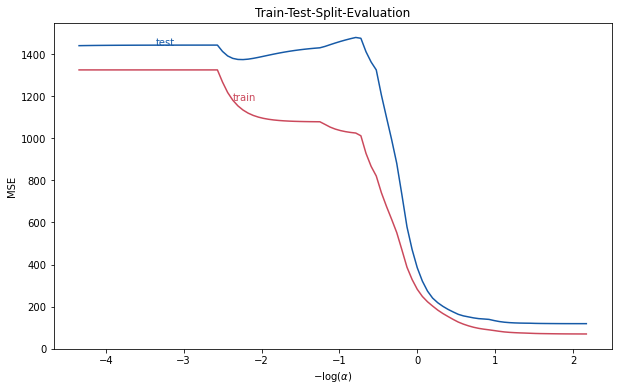

In [46]:
# Visualize the effects of regularization on overfitting
alphas = np.exp(np.linspace(10, -5, 100))
mse = pd.DataFrame([fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=50000),
                           X_train, X_test, y_train, y_test)
                    for alpha in alphas])
mse["log_alpha"] = -np.log10(alphas)
fig, ax = plt.subplots(figsize=(10,6))
mse.plot(x="log_alpha", y="mse_test", c=colors[0], ax=ax)
mse.plot(x="log_alpha", y="mse_train", c=colors[1], ax=ax)
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
ax.set_title("Train-Test-Split-Evaluation")
ax.get_legend().remove()
ax.annotate("test",(mse.log_alpha[15], mse.mse_test[15]),color=colors[0])
ax.annotate("train",(mse.log_alpha[30], mse.mse_train[30]),color=colors[1])

### 5.3 Cross-Validation

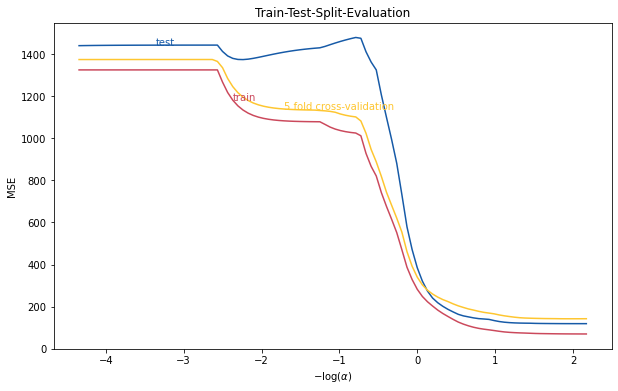

In [47]:
# 5-fold, cross-validated MSE 
from sklearn.model_selection import cross_val_score
mse["cv"] = [-np.mean(cross_val_score(linear_model.Lasso(alpha=alpha, max_iter=50000),
                                  X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
          for alpha in alphas]
mse.plot(x="log_alpha", y="cv", c=colors[2], ax=ax)
ax.annotate("5 fold cross-validation", (mse.log_alpha[40], mse.cv[40]), color=colors[2])
ax.get_legend().remove()
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
fig

Cross-Validation optimum $\alpha$ automated selection:

In [48]:
lasso = linear_model.LassoCV(cv=6).fit(X_train,y_train)
print(f"Lasso training alpha is {lasso.alpha_}")
print(f"Lasso training -log(alpha) is {-np.log10(lasso.alpha_)}")
print(f"MSE at lasso alpha: {fit_and_report_mses(linear_model.Lasso(alpha=lasso.alpha_),X_train, X_test, y_train, y_test)}")

Lasso training alpha is 126084.47503646002
Lasso training -log(alpha) is -5.100661614558163
MSE at lasso alpha: {'mse_train': 1326.5977954311556, 'mse_test': 1428.7706487642984}


In [49]:
#lasso.alphas_
param_grid = {"alpha": np.exp(np.linspace(10, -5, 100))}
lasso_grid = sklearn.model_selection.GridSearchCV(linear_model.Lasso(), param_grid, cv=6, scoring = "neg_mean_squared_error")
lasso_grid.fit(X_train, y_train)
lasso_best = lasso_grid.best_estimator_
lasso_best

Lasso(alpha=0.007840247717611612)

## 6. Random Forests and Neural Network

### 6.1 Random Trees

In this sector, we use randome trees/forests to understand if it makes sense to inctroduce one feature into the regression. In particular, latitude and longitude in the merged data set represent geographical locations, while their numerical value do not exhiibit too much meaningful iniformation and only carry relative geographical locations. 

Random trees are made inpreparation for the forests.

Latitude Random Tree

Text(0.5, 1.0, 'Latitude Random Tree')

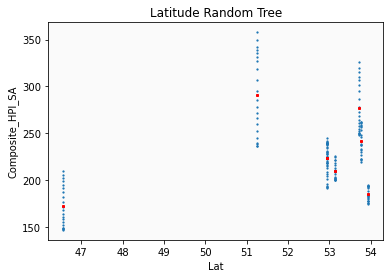

In [50]:
from sklearn import tree
ax_lat = var_scatter(mls_covid, var="Lat")
lat_tree = tree.DecisionTreeRegressor(max_depth=10).fit(X_all[["Lat"]],y)
scatter_model(lat_tree, X_all[["Lat"]], ax_lat, x="Lat", color="red")
ax_lat.set_facecolor(bgcolor)
ax_lat.set_title("Latitude Random Tree")

Longitude Random Tree

Text(0.5, 1.0, 'Longitude Random Tree')

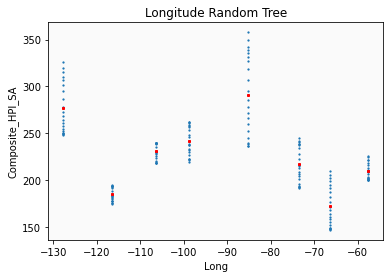

In [51]:
ax_long = var_scatter(mls_covid, var="Long")
long_tree = tree.DecisionTreeRegressor(max_depth=10).fit(X_all[["Long"]],y)
scatter_model(long_tree, X_all[["Long"]], ax_long, x="Long", color="red")
ax_long.set_facecolor(bgcolor)
ax_long.set_title("Longitude Random Tree")

### 6.2 Random Forests

Then, implement random forests and corss-validation to find out maximum tree depths and report MSE:

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)

param_grid = {'max_depth': [1, 2, 4, 8, 16, 32, None] } # tree depths to try
rf_grid = sklearn.model_selection.GridSearchCV(sklearn.ensemble.RandomForestRegressor(n_estimators=25), 
                                               param_grid, cv=6, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_ 

mse_training = metrics.mean_squared_error(y_train, rf_best.predict(X_train))
mse_testing = metrics.mean_squared_error(y_test, rf_best.predict(X_test))
print(f"Random Forests MSE for training set: {mse_training}")
print(f"Random Forests MSE for testing set: {mse_testing}")

Random Forests MSE for training set: 6.966774760850141
Random Forests MSE for testing set: 31.56897697480203


In [53]:
rf_best

RandomForestRegressor(n_estimators=25)

### 6.3 Neural Network

Fit a neural network to the training data (pre-defined in sector 5). And use cross-validation to select the best network architecture (number of layers and widths of layers):

In [54]:
# Input scaling/normalizing
basemodel = pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    neural_network.MLPRegressor((10,), activation = "relu",
                                solver = "adam", learning_rate_init = 0.1,
                                max_iter=1000, verbose = False, batch_size=200)
)
#basemodel.get_params().keys()
#basemodel.fit(X_train, y_train)
#metrics.mean_squared_error(y_test, basemodel.predict(X_test))

In [55]:
# Multi-layer Perceptron regressor
param_grid = {'mlpregressor__hidden_layer_sizes': [(10,), (15,), (5,5), (10,5), (15,5), (10,10)]}   
nn_grid = sklearn.model_selection.GridSearchCV(basemodel, param_grid, cv=5, scoring = "neg_mean_squared_error")
nn_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('mlpregressor',
                                        MLPRegressor(batch_size=200,
                                                     hidden_layer_sizes=(10,),
                                                     learning_rate_init=0.1,
                                                     max_iter=1000))]),
             param_grid={'mlpregressor__hidden_layer_sizes': [(10,), (15,),
                                                              (5, 5), (10, 5),
                                                              (15, 5),
                                                              (10, 10)]},
             scoring='neg_mean_squared_error')

In [56]:
nn_best = nn_grid.best_estimator_
nn_best

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(batch_size=200, hidden_layer_sizes=(15, 5),
                              learning_rate_init=0.1, max_iter=1000))])

In [57]:
print(f"MLP traininig MSE = {metrics.mean_squared_error(y_train, nn_best.predict(X_train))}")
print(f"MLP testing MSE = {metrics.mean_squared_error(y_test, nn_best.predict(X_test))}")

MLP traininig MSE = 0.008397772189027538
MLP testing MSE = 2662.7587320422654


Text(0.5, 1.0, 'Neural Network prediction')

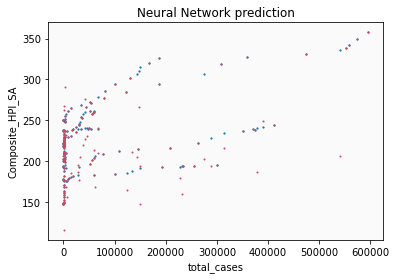

In [58]:
ax = var_scatter(mls_covid)
scatter_model(nn_best, X_all, ax=ax)
ax.set_facecolor(bgcolor)
ax.set_title("Neural Network prediction")

Awesome! By using neural network, we have successfully constructed a (so far) best model to make predictions on composite HPI. We get a scatter plot of the predictions that looks very similar to the observed HPI data points.

## 7. Summary and Further Studies

$\textbf{Summary to the COVID & Housing price index project:}$  
- Linear model: From our linear model with geographical location control varibles and time/province fixed effects, we can conclude that the number of total confirmed COVID case number does NOT have a statistically significant effect on the composite housing price index across Canada. 

- Lasso model with corss-validation: We learned that the worrisome "inflation" effect on average housing price is negligible (or say statistically insignificant). This is because the COVID pandemic started from early 2020 and from early 2020 to October 2021, it is a relatively short time span. But we can reasonably expect that inflation will be playing a more significant role in pushing housing prices as we eexpand the experiment timeline. More emphasis should be placed on provincial idiosyncrast. British Columbia and Ontario are two "hottest" provinces that are exhibiting a very large effect on the rise of housing price index. It also makes sense because we have learned that BC and Ontatrio have the most outrageous housing prices compared to any other provinces in Canada. Interestingly, Quebec province is actuallly dragging down the average housing price index. 

- Random forests model and Neural networks model: They offered us more advanced insights into the application of machine learning into housing price and COVID analysis. What is the "best" model for a particular research question remains a million-dollar question. But at least, we can use different models to make corresponding predictions about it. While comparing the mean squared errors, we should always be mindful about overfitting (or potentially under-fitting which is not talked about in this project) 

$\textbf{Further studies:}$ There are actually much more fun things can be done for this topic, for example:
- In terms of housing prices, this project primarily focused on an "averaged", "composite" and "scaled" perspective on housing price indexes. But there are more information on specific types of real estate properties (i.e., apartment, townhouse, single house, one/two storey houses). It may be also very interesting to see how different types of houses react to COVID pandemic. I imagine different types of properties should be behaving differently in that they have different characteristics/ different consumer groups/...) 

- In terms of COVID cases, this project primarily concentrated on the total confirmed COVID case numbers, with some discussion of the total number of deaths. What I think would also be meaningful to investigate is that we can look into the dynamic relationship between daily active case numebers/ daily new case numbers and MLS housing prices across provinces in Canada. 


## 8. Reference List

1. Textbook: QuantEcon--[Regression](https://datascience.quantecon.org/applications/regression.html), [Mapping in Python](https://datascience.quantecon.org/applications/maps.html), [Visualizing Corona Virus](https://github.com/ubcecon/ECON323_2021_Fall/blob/7d8d5654e435e09a90880529066df69aeccb5490/extra_notebooks/covid-trends.ipynb)
2. Data source: 
- COVID data: [JHU CSSE](https://github.com/CSSEGISandData/COVID-19)
- MLS® HPI data: [CREA (Canadian Real Estate Association)](https://www.crea.ca/housing-market-stats/mls-home-price-index/)
- Canadian provincial geographical data: [Statistics Canada](https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2016-eng.cfm)
3. Visualization inspiration: [COVID-19 data processing with Pandas DataFrame](https://towardsdatascience.com/covid-19-data-processing-58aaa3663f6)
4. Regularization/Random Forests/Neural Network: ECON323 PS7